# Unzip GTZAN playlist

In [7]:
import zipfile
import os

# Define the path to the zip file and the destination directory
zip_file_path = '../cache/gtzan/archive.zip'
unpack_dir = '../cache/gtzan/'

# Create the destination directory if it doesn't exist
os.makedirs(unpack_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unpack_dir)

print(f"Contents unpacked to {unpack_dir}")


Contents unpacked to ../cache/gtzan/


# Calculate Features

In [1]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm


In [78]:
# Initialize a list to store the feature data
data = []

ssd_cap = 200
ssd_looper = 0
gtzan_cap = 100
gtzan_looper = 0

In [79]:
# Function to extract features from a given .wav file
def extract_features(file_path, label):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        # Extract features
        length = librosa.get_duration(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        harmony = librosa.effects.harmonic(y)
        perceptr = librosa.effects.percussive(y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # Calculate ASR (Articulation Feature)
        rms_energy = rms[0]
        asr = np.sum(rms_energy < np.mean(rms_energy)) / len(rms_energy)

        # Calculate Onset Envelope Features
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        oenv_mean = np.mean(onset_env)
        oenv_var = np.var(onset_env)
        oenv_std = np.std(onset_env)

        # Calculate Spectral Flatness Features
        flatness = librosa.feature.spectral_flatness(y=y)
        flatness_mean = np.mean(flatness)
        flatness_var = np.var(flatness)
        flatness_std = np.std(flatness)

        # Aggregate features
        features = [
            os.path.basename(file_path),
            length,
            np.mean(chroma_stft), np.var(chroma_stft),
            np.mean(rms), np.var(rms), np.std(rms),
            np.mean(spectral_centroid), np.var(spectral_centroid),
            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
            np.mean(rolloff), np.var(rolloff), np.std(rolloff),
            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
            np.mean(harmony), np.var(harmony),
            np.mean(perceptr), np.var(perceptr),
            tempo[0],
            asr,
            oenv_mean, oenv_var, oenv_std,
            flatness_mean, flatness_var, flatness_std
        ]

        # Add MFCC features (only means as per the paper)
        for i in range(20):
            features.append(np.mean(mfcc[i]))

        # Append the label
        features.append(label)

        return features
    
    except Exception as e:
        # If an error occurs, print the error and skip this file
        print(f"Error processing {file_path}: {e}")
        return None
    
def loop_over_dir(dir_name):
    
    def get_label(dir_name):
        if 'sleep' in dir_name: return 'Spotify Sleep Dataset'
        elif 'ssd_512_256' in dir_name: return 'Generated 512,256 Spotify Sleep Dataset'
        elif 'ssd_2048_128' in dir_name: return 'Generated 2048,128 Spotify Sleep Dataset'
        elif 'fma_pop' in dir_name: return 'FMA POP'
        elif 'musiccaps' in dir_name: return 'MusicCaps' 
        elif 'drum' in dir_name: return 'Drum Samples'
    
    if 'gtzan' in dir_name:
        for genre in os.listdir(dir_name):
            genre_dir = os.path.join(dir_name, genre)
            if os.path.isdir(genre_dir):
                gtzan_looper = 0
                for filename in tqdm(os.listdir(genre_dir), desc=f'Processing GTZAN dataset genre: {genre_dir}'):
                    if gtzan_looper < gtzan_cap:
                        if filename.endswith(('.wav', '.mp3')):
                            file_path = os.path.join(genre_dir, filename)
                            features = extract_features(file_path, label=genre)
                            if features is not None:  # Skip files that failed to process
                                data.append(features)
                                gtzan_looper += 1
    else:
        ssd_looper = 0
        for filename in tqdm(os.listdir(dir_name), desc=f'Processing {dir_name} dataset'):
            if ssd_looper < ssd_cap:
                if filename.endswith(('.wav', '.mp3')):
                    file_path = os.path.join(dir_name, filename)
                    features = extract_features(file_path, label=get_label(dir_name))
                    if features is not None:  # Skip files that failed to process
                        data.append(features)
                        ssd_looper += 1

In [80]:
# Directory paths
spotify_directory = '../cache/spotify_sleep_dataset/waveform'
gtzan_directory = '../cache/gtzan/Data/genres_original'
fma_pop_directory = '../cache/fma_pop/waveform/'
musiccaps_directory = '../cache/musiccaps/waveform'
drum_samples_directory = '../cache/drum_samples/waveform'
generated_sleep_samples_512_256 = '../models/ra_ssd_512_256/model_step_50000/samples/audio/sch_ddpm_nisteps_1000'
generated_sleep_samples_2048_128 = '/home/th716/audio-diffusion/models/ra_ssd_2048_128/model_step_90000/samples/audio/sch_ddpm_nisteps_1000'

for dir_name in [generated_sleep_samples_512_256, generated_sleep_samples_2048_128]:
    loop_over_dir(dir_name)

# Define column names
columns = [
    'filename', 'length', 'chroma_stft_mean', 'chroma_stft_var',
    'rms_mean', 'rms_var', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'rolloff_std',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var',
    'perceptr_mean', 'perceptr_var', 'tempo', 'asr',
    'oenv_mean', 'oenv_var', 'oenv_std',
    'flatness_mean', 'flatness_var', 'flatness_std'
]

# Add MFCC columns
for i in range(1, 21):
    columns.append(f'mfcc{i}_mean')

# Add label column
columns.append('label')

Processing ../models/ra_ssd_512_256/model_step_50000/samples/audio/sch_ddpm_nisteps_1000 dataset: 100%|██████████| 1027/1027 [01:40<00:00, 10.21it/s]
Processing /home/th716/audio-diffusion/models/ra_ssd_2048_128/model_step_90000/samples/audio/sch_ddpm_nisteps_1000 dataset: 100%|██████████| 1024/1024 [07:10<00:00,  2.38it/s]


In [82]:
df = pd.DataFrame(data, columns=columns)
df.to_csv('csv/musical_features.csv', index=False)

print('Feature extraction complete. Saved to musical_features.csv')

Feature extraction complete. Saved to musical_features.csv


In [99]:
df['label'].unique()

array(['gtzan: Generated 512,256 Spotify Sleep Dataset',
       'gtzan: Generated 2048,128 Spotify Sleep Dataset',
       'Spotify Sleep Dataset', 'gtzan: disco', 'gtzan: rock',
       'gtzan: blues', 'gtzan: country', 'gtzan: pop', 'gtzan: classical',
       'gtzan: hiphop', 'gtzan: jazz', 'gtzan: reggae', 'gtzan: metal',
       'FMA Pop', 'MusicCaps', 'Drum Samples'], dtype=object)

In [112]:
df = pd.read_csv('csv/musical_features.csv')

In [113]:
df['label'].unique()

array(['Generated 512,256 Spotify Sleep Dataset',
       'Generated 2048,128 Spotify Sleep Dataset', 'sleep', 'disco',
       'rock', 'blues', 'country', 'pop', 'classical', 'hiphop', 'jazz',
       'reggae', 'metal', 'FMA POP', 'MusicCaps', 'Drum Samples'],
      dtype=object)

In [114]:
def clean_up_label(txt):
    if txt in ['disco', 'rock', 'blues', 'country', 'pop', 'classical', 'hiphop', 'jazz', 'reggae', 'metal']:
        return f'gtzan: {txt}'
    elif txt == 'sleep':
        return 'Spotify Sleep Dataset'
    else: 
        return txt
    
df['label'] = df['label'].apply(lambda x: clean_up_label(x))

In [115]:
df['label'].unique()

array(['Generated 512,256 Spotify Sleep Dataset',
       'Generated 2048,128 Spotify Sleep Dataset',
       'Spotify Sleep Dataset', 'gtzan: disco', 'gtzan: rock',
       'gtzan: blues', 'gtzan: country', 'gtzan: pop', 'gtzan: classical',
       'gtzan: hiphop', 'gtzan: jazz', 'gtzan: reggae', 'gtzan: metal',
       'FMA POP', 'MusicCaps', 'Drum Samples'], dtype=object)

In [117]:
from sklearn.preprocessing import MinMaxScaler

exclude_columns = ['filename', 'length', 'label']

df_n = df.copy()

scaler = MinMaxScaler()

df_n.loc[:, ~df_n.columns.isin(exclude_columns)] = scaler.fit_transform(
    df_n.loc[:, ~df_n.columns.isin(exclude_columns)]
)

df_n.to_csv('csv/musical_features_all_normalized.csv', index=False)

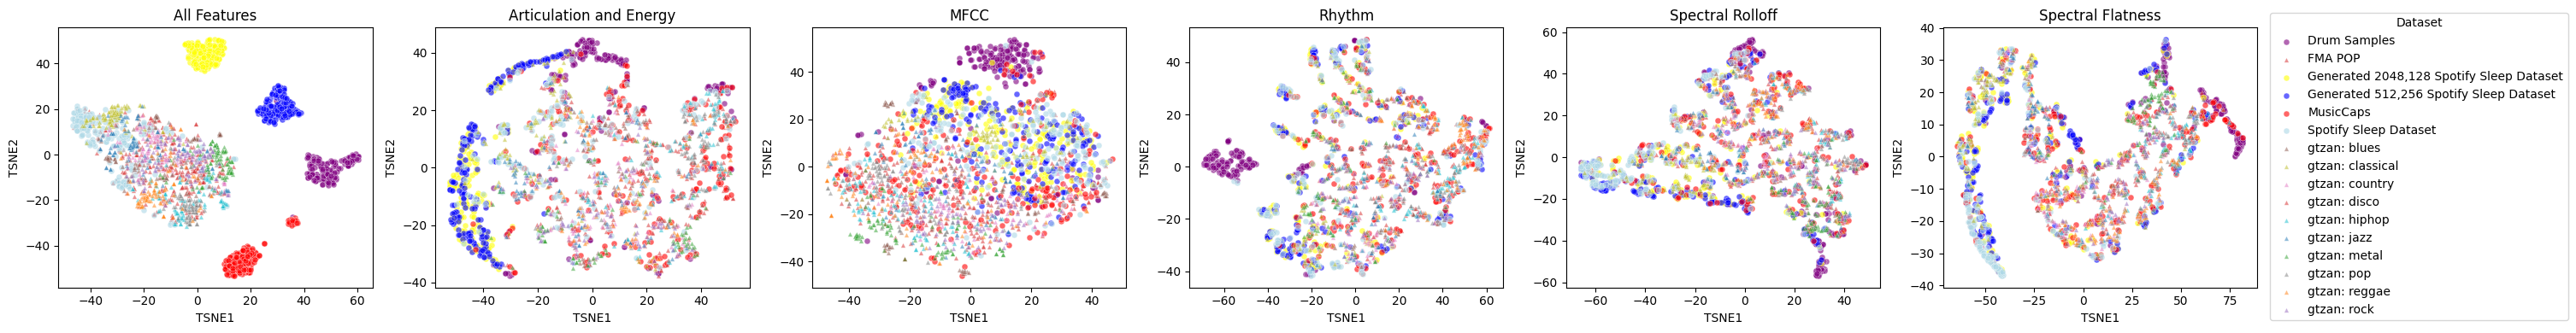

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': df_n.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette for the highlighted labels
highlight_labels = {
    'Spotify Sleep Dataset': 'lightblue',
    'Generated 512,256 Spotify Sleep Dataset': 'blue',
    'Generated 2048,128 Spotify Sleep Dataset': 'yellow',
    'FMA Pop': 'orange',
    'MusicCaps': 'red',
    'Drum Samples': 'purple'
}

# Generate a palette for the remaining labels
unique_labels = df_n['label'].unique()
palette = sns.color_palette("tab10", len(unique_labels))
palette_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to plot t-SNE on a given axis
def plot_tsne(ax, features, title):
    X = df_n[features].values
    y = df_n['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    # Plot the labels
    for label in np.unique(y):
        if label in highlight_labels:
            color = highlight_labels[label]
            size = 25  # Larger points for highlighted labels
            alpha = 0.6  # Bold colors
            marker = 'o'
        else:
            color = palette_dict[label]
            size = 15  # Smaller points for other labels
            alpha = 0.5  # Washed out color
            marker = '^'
        
        sns.scatterplot(
            x='TSNE1', y='TSNE2',
            data=tsne_df[tsne_df['label'] == label],
            color=color,
            s=size,
            alpha=alpha,
            marker=marker,
            ax=ax,
            label=label
        )
    
    ax.set_title(title)
    ax.legend_.remove()  # Remove individual legends

# Create subplots
fig, axs = plt.subplots(1, len(feature_groups), figsize=(28, 4), sharex=False, sharey=False)

# Plot each t-SNE
for ax, (name, features) in zip(axs, feature_groups.items()):
    plot_tsne(ax, features, f'{name}')

# Create a single legend directly to the right of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Dataset', bbox_to_anchor=(0.95, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make space for the legend
plt.savefig('images/musical_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df[]

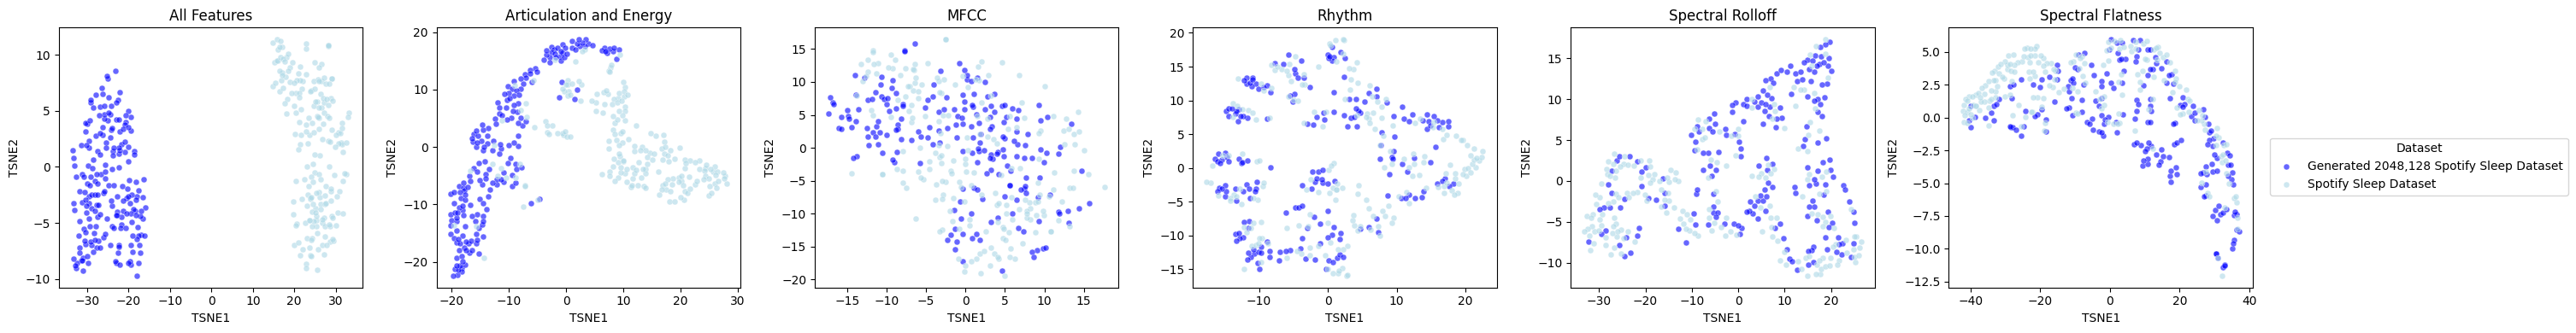

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

labels_to_keep = ['Spotify Sleep Dataset', 'Generated 2048,128 Spotify Sleep Dataset']
filtered_df = df_n[df_n['label'].isin(labels_to_keep)]

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': filtered_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette for the highlighted labels
highlight_labels = {
    'Spotify Sleep Dataset': 'lightblue',
    'Generated 2048,128 Spotify Sleep Dataset': 'blue',
}




# Generate a palette for the remaining labels
unique_labels = filtered_df['label'].unique()
palette = sns.color_palette("tab10", len(unique_labels))
palette_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to plot t-SNE on a given axis
def plot_tsne(ax, features, title):
    X = filtered_df[features].values
    y = filtered_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    # Plot the labels
    for label in np.unique(y):
        if label in highlight_labels:
            color = highlight_labels[label]
            size = 25  # Larger points for highlighted labels
            alpha = 0.6  # Bold colors
            marker = 'o'
        else:
            color = palette_dict[label]
            size = 15  # Smaller points for other labels
            alpha = 0.5  # Washed out color
            marker = '^'
        
        sns.scatterplot(
            x='TSNE1', y='TSNE2',
            data=tsne_df[tsne_df['label'] == label],
            color=color,
            s=size,
            alpha=alpha,
            marker=marker,
            ax=ax,
            label=label
        )
    
    ax.set_title(title)
    ax.legend_.remove()  # Remove individual legends

# Create subplots
fig, axs = plt.subplots(1, len(feature_groups), figsize=(28, 4), sharex=False, sharey=False)

# Plot each t-SNE
for ax, (name, features) in zip(axs, feature_groups.items()):
    plot_tsne(ax, features, f'{name}')

# Create a single legend directly to the right of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Dataset', bbox_to_anchor=(0.95, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make space for the legend
plt.savefig('images/musical_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### TODO

- make plot with only spotify sleep dataset and generated dataset

### Musical Feature Analysis

In [40]:
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']


In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with all the features and 'label' column
df = pd.read_csv("musical_features_all.csv")  # Load your DataFrame

# Define the feature groups based on your clarification
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping features as described
feature_groups = {
    "All 34 musical features": df.drop(columns=['filename', 'label', 'length']),
    "Only articulation and energy features": df[articulation_energy_features],
    "Only MFCC features": df[mfcc_features],
    "Only rhythm features": df[rhythm_features],
    "Only spectral rolloff features": df[spectral_rolloff_features],
    "Only spectral flatness features": df[spectral_flatness_features]
}

# Labels to focus on
labels_of_interest = ['Drum Samples', 'FMA Pop', 'MusicCaps', 'Spotify Sleep Dataset', 'Spotify Sleep Dataset Generated']

# Initialize results DataFrame
results = []

# Process each group of features
for label in labels_of_interest:
    # Create a binary label: 1 for the current label, 0 for all others
    binary_labels = df['label'].apply(lambda x: 1 if x == label else 0)

    for subset_name, features in feature_groups.items():
        # Standardize the features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply K-means clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)
        
        # Calculate ARS and SC
        ars = adjusted_rand_score(binary_labels, clusters)
        sc = silhouette_score(scaled_features, clusters)
        
        # Append results
        results.append([label, subset_name, ars, sc])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=["Label", "Musical Feature Subset", "ARS", "SC"])

# Display the results DataFrame
display(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('musical_feature_analysis_results.csv', index=False)


,Label,Musical Feature Subset,ARS,SC
0,Drum Samples,All 34 musical features,-0.030945,0.117314
1,Drum Samples,Only articulation and energy features,0.026593,0.455172
2,Drum Samples,Only MFCC features,0.012511,0.213975
3,Drum Samples,Only rhythm features,-0.062123,0.400754
4,Drum Samples,Only spectral rolloff features,0.060715,0.431030
5,Drum Samples,Only spectral flatness features,0.342660,0.919204
6,FMA Pop,All 34 musical features,0.012341,0.117314
7,FMA Pop,Only articulation and energy features,0.071674,0.455172
8,FMA Pop,Only MFCC features,0.015501,0.213975
9,FMA Pop,Only rhythm features,-0.003110,0.400754


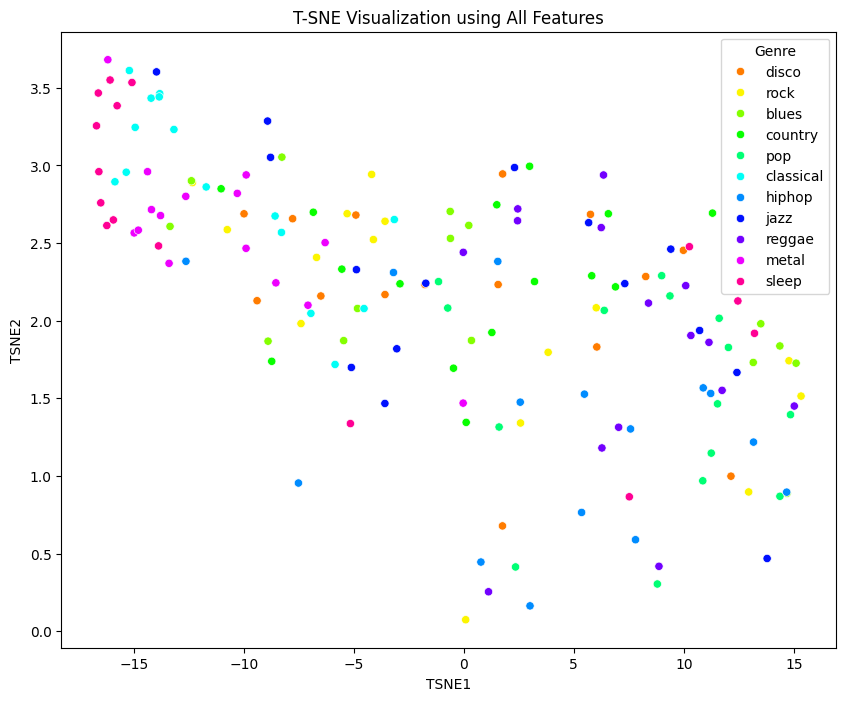

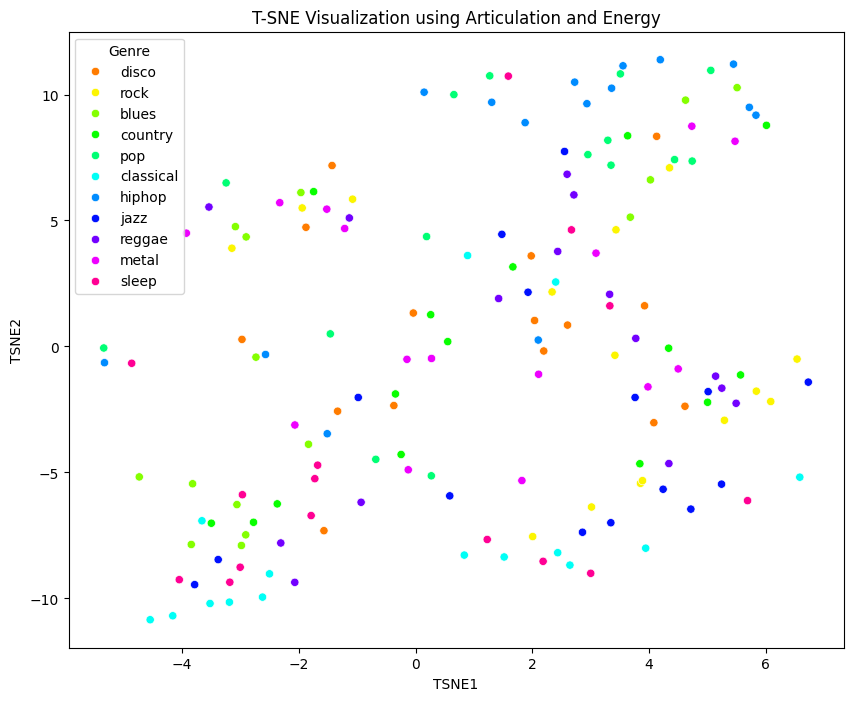

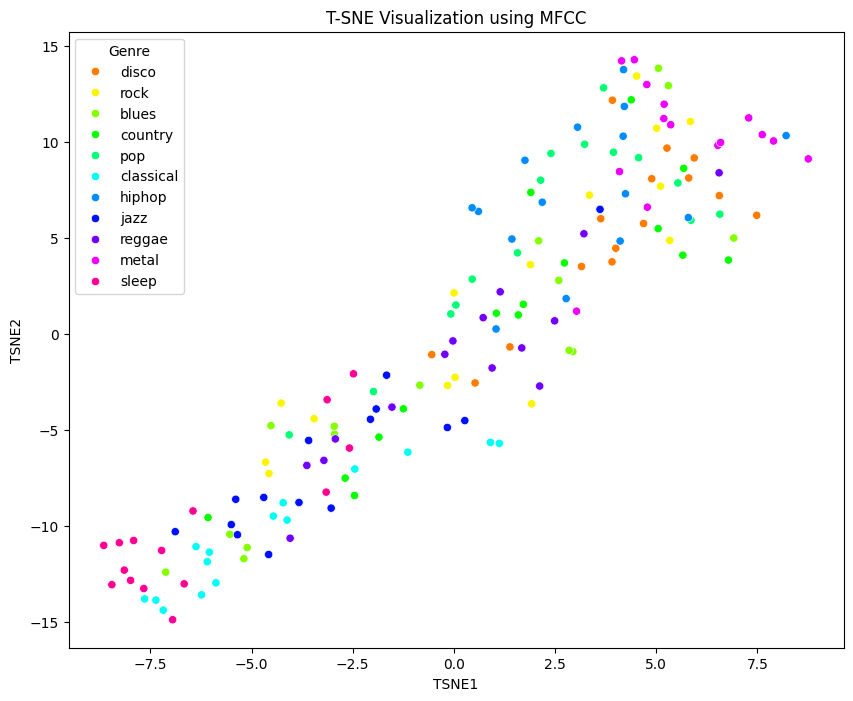

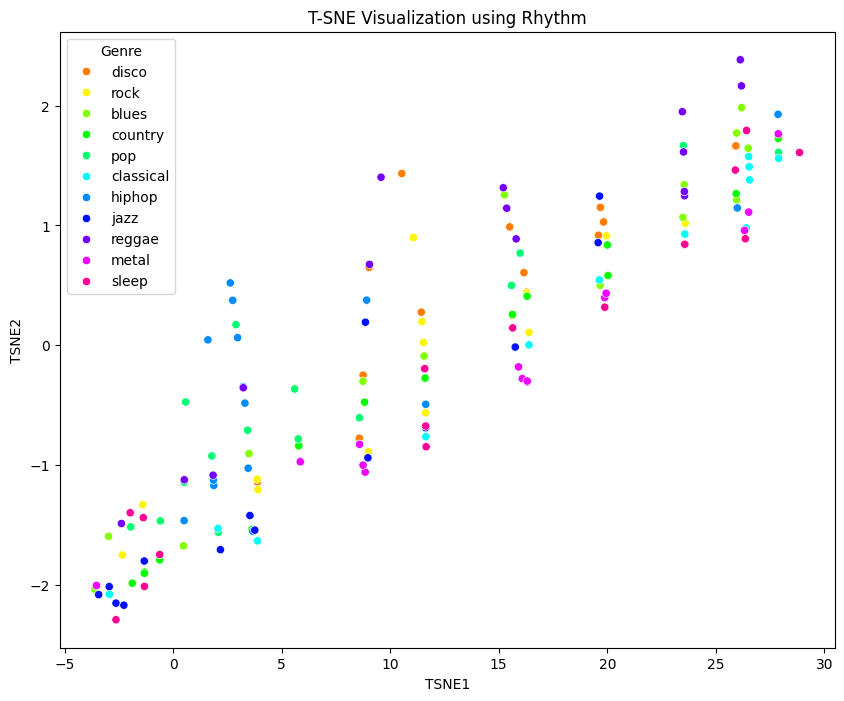

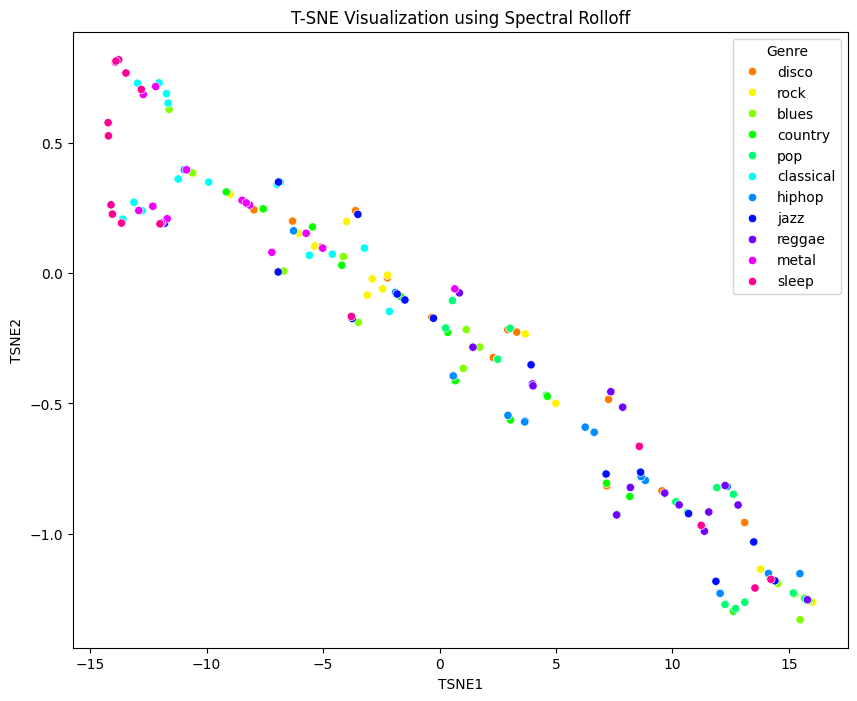

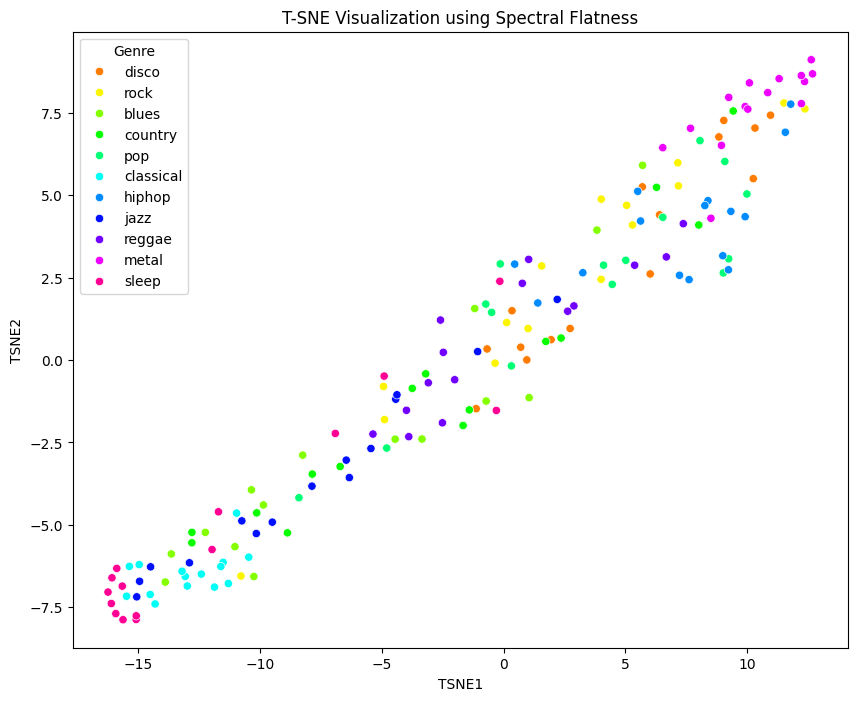

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': features_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette with enough unique colors
unique_labels = features_df['label'].unique()
palette = sns.color_palette("hsv", len(unique_labels))

# Function to plot t-SNE
def plot_tsne(features, title):
    X = features_df[features].values
    y = features_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette=palette)
    plt.title(title)
    plt.legend(loc='best', title='Genre')
    plt.show()

# Generate t-SNE plots for each feature group
for name, features in feature_groups.items():
    plot_tsne(features, f'T-SNE Visualization using {name}')


# Load Audio Datasets

In [26]:
import librosa
import os
import numpy as np
from tqdm import tqdm

def load_and_preprocess_audio(file_path, duration=30, sr=16000):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio

# Example: Load and preprocess all files in a directory
sleep_music_dir = '../cache/spotify_sleep_dataset/waveform'

sleep_music_files = [os.path.join(sleep_music_dir, f) for f in os.listdir(sleep_music_dir) if (f.endswith('.wav') or f.endswith('.mp3'))]

# Using tqdm for progress tracking
sleep_music = {_file:load_and_preprocess_audio(_file) for _file in tqdm(sleep_music_files, desc="Processing sleep music files")}


### Extract Musical Features

In [28]:
def calculate_asr(audio):
    rms = librosa.feature.rms(y=audio)
    mean_rms = np.mean(rms)
    silence_ratio = np.mean(rms < mean_rms)
    return silence_ratio

def calculate_energy_features(audio):
    rms = librosa.feature.rms(y=audio)
    return np.mean(rms), np.var(rms), np.std(rms)

def calculate_mfcc_features(audio, sr=16000):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    return np.mean(mfccs, axis=1)

def calculate_rhythm_features(audio, sr=16000):
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo, np.mean(onset_env), np.var(onset_env), np.std(onset_env)

def calculate_spectral_rolloff(audio, sr=16000):
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    return np.mean(rolloff), np.var(rolloff), np.std(rolloff)

def calculate_spectral_flatness(audio):
    flatness = librosa.feature.spectral_flatness(y=audio)
    return np.mean(flatness), np.var(flatness), np.std(flatness)

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)



# Calculate ASR for all music pieces
# sleep_asr = [calculate_asr(audio) for audio in sleep_music]
# other_asr = [calculate_asr(audio) for audio in other_music]


In [27]:
len(sleep_music)

11482

In [31]:
from tqdm import tqdm

sleep_asr = {audio_file: calculate_asr(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating ASR")}
sleep_energy = {audio_file: calculate_energy_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Energy Features")}
sleep_mfcc_features = {audio_file: calculate_mfcc_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating MFCC Features")}
sleep_rhythm_features = {audio_file: calculate_rhythm_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Rhythm Features")}
sleep_spectral_rolloff = {audio_file: calculate_spectral_rolloff(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Rolloff")}
sleep_spectral_flatness = {audio_file: calculate_spectral_flatness(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Flatness")}

Calculating Spectral Flatness: 100%|██████████| 11482/11482 [04:57<00:00, 38.58it/s]


In [33]:
import pandas as pd

all_features = {}
for audio_file in sleep_music.keys():
    all_features[audio_file] = {
        "ASR": sleep_asr[audio_file],
        "Energy": sleep_energy[audio_file],
        "MFCC": sleep_mfcc_features[audio_file],
        "Rhythm": sleep_rhythm_features[audio_file],
        "Spectral Rolloff": sleep_spectral_rolloff[audio_file],
        "Spectral Flatness": sleep_spectral_flatness[audio_file],
    }

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(all_features, orient='index')

# Save the DataFrame to a CSV file
df.to_csv("sleep_music_features.csv", index_label="Audio File")

print("CSV file 'sleep_music_features.csv' has been created.")

Calculating ASR:   2%|▏         | 277/11482 [1:46:27<71:46:33, 23.06s/it]


CSV file 'sleep_music_features.csv' has been created.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Concatenate features for clustering
sleep_features = np.hstack([normalized_sleep_asr, normalized_sleep_energy, sleep_mfcc_features, 
                            sleep_rhythm_features, sleep_spectral_rolloff, sleep_spectral_flatness])

other_features = np.hstack([normalized_other_asr, normalized_other_energy, other_mfcc_features, 
                            other_rhythm_features, other_spectral_rolloff, other_spectral_flatness])

all_features = np.vstack([sleep_features, other_features])
labels = np.array([0] * len(sleep_features) + [1] * len(other_features))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_features)
predicted_labels = kmeans.labels_

# Calculate ARS and Silhouette Coefficient
ars = adjusted_rand_score(labels, predicted_labels)
sc = silhouette_score(all_features, predicted_labels)

print(f'Adjusted Rand Score (ARS): {ars}')
print(f'Silhouette Coefficient (SC): {sc}')

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_results = tsne.fit_transform(all_features)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm')
plt.title('t-SNE Visualization of Music Features')
plt.show()
